In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

# Let us write a function that solves th eigenvalue problem for the specific case of a square

In [2]:
def solve_eigenproblem_square(parameters, energy = 1e-6, number_of_bands = int(1)):
    '''Calculate and plot bands in x direction.
        This function assumes that the only possible non-orthogonal degenerate states are at zero energy.'''
    
    #Generate Peierls phases
    np.random.seed(0)
    fluxes = tb.make_fluxes(parameters)
    a_e, a_n = tb.vector_potential(parameters,fluxes)
    parameters['a_e'] = a_e
    parameters['a_n'] = a_n

    #Solve generalised eigenproblem
    Phi, H, P, deleted_indices = tb.operators_square(parameters)
    eigenvalues, eigenvectors = sla.eigsh(H, M=P, k = number_of_bands, tol = 0, sigma = energy, which = 'LM',return_eigenvectors = True)

    #Refill with zeros the deleted spins
    states = np.zeros((2*Nx*Ny,number_of_bands),dtype = complex)
    count = 0
    for index in range(2*Nx*Ny):
        if index not in deleted_indices:
            states[index] = (Phi@eigenvectors)[index-count]
        else:
            count += 1

    #Now make sure they are orthogonal
    overlaps = states.conjugate().transpose()@states
    ##The overlap can only be non-zero for degenerate states
    degenerate_indices = []
    bulk_indices = []    
    for i in range(overlaps.shape[0]):
        sorted = np.flip(np.sort(np.abs(overlaps[i])))
        if sorted[1]/sorted[0]<0.1: #This threshold (0.1) is a bit arbitrary
            bulk_indices.append(i)
        else:
            degenerate_indices.append(i)

    overlaps_deg = np.delete(overlaps, bulk_indices, axis=0)
    overlaps_deg = np.delete(overlaps_deg, bulk_indices, axis=1)
    overlaps_bulk = np.delete(overlaps, degenerate_indices, axis=0)
    overlaps_bulk = np.delete(overlaps_bulk, degenerate_indices, axis=1)

    states_deg = np.delete(states, bulk_indices, axis=1)
    states_bulk = np.delete(states, degenerate_indices, axis=1)

    evalues, orthogonal_coeff = np.linalg.eigh(overlaps_deg)
    orthogonal = np.append(states_deg@orthogonal_coeff, states_bulk , axis=1) #### These are finally the orthogonalised states
    norm = np.sqrt(np.diag(np.abs(orthogonal.conjugate().transpose()@orthogonal)))
    states = orthogonal/norm[None,:]
    
    # Rebuild state
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)

    ##### This following part is specific for the square ######
      # Now rotate back the spins on the edge
    theta = parameters['theta']
    for x in range(Nx-1):
        rotation = spin_rotation([x,0], theta, pi)
        states = rotation@states

    for y in range(Ny-1):
        rotation = spin_rotation([0,y+1], theta, pi/2)
        states = rotation@states
        
    for x in range(Nx-1):
        rotation = spin_rotation([x+1,Ny-1], theta, 0)
        states = rotation@states
        
    for y in range(Ny-1):
        rotation = spin_rotation([Nx-1,y], theta,-np.pi/2)
        states = rotation@states

    ###Now reshape
    states_shaped = np.reshape(states.flatten('F'), newshape = (number_of_bands,2,Ny,Nx), order = 'C')

    ### Now assign again energies
    energies = np.zeros(number_of_bands)
    for i in range(number_of_bands):
        if i in degenerate_indices:
            energies[i] = 0 #This should be zero
        else:
            energies[i] = eigenvalues[i]
    
    return energies, states_shaped, degenerate_indices

## Use the function

In [16]:
thetas = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

i = 7 ### selected value of thea!!
Nx = 41 #Assume translational invariance in x direction
Ny = 41
nbands = int((Nx*Ny)/100*16)
print('Bands to calculate: ',nbands)


parameters = dict(
    Nx = Nx,
    Ny = Ny,
    B1 = 0, # no magnetic field
    N1 = 0, #
    d1 = 0, # These are irrelevant for B1 = 0
    N2 = 0, #
    potential = lambda x,y:0.0*np.random.rand(Ny,Nx),
    mass = lambda x,y:0*x,
    disorder = 0,
    theta = -(pi/2)*(thetas[i]/100),
)

Bands to calculate:  268


In [17]:
ener, states, degenerate_indices = solve_eigenproblem_square(parameters, number_of_bands = nbands)

/tmp/ipykernel_42368/3727956006.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_42368/3727956006.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (3,3))


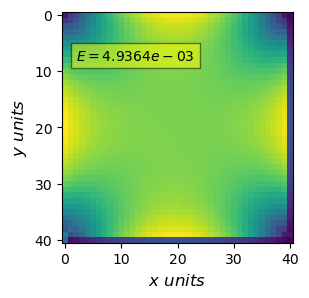

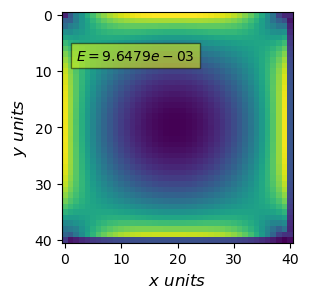

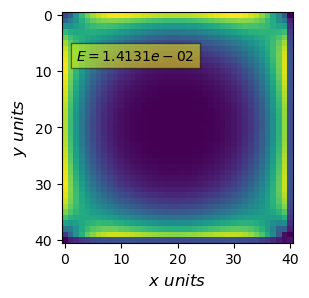

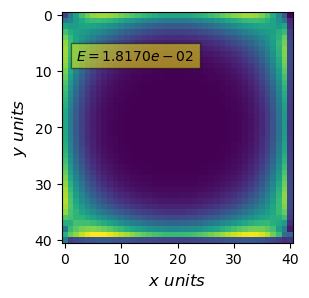

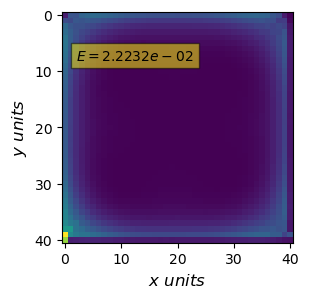

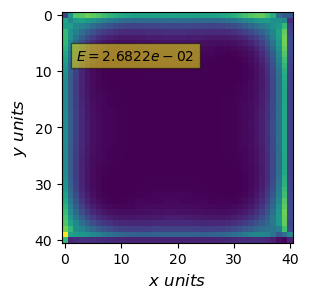

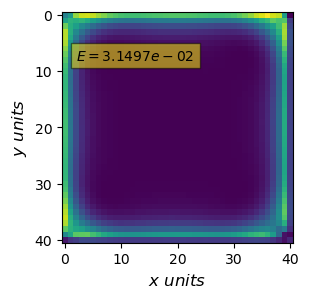

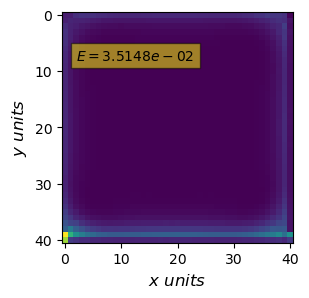

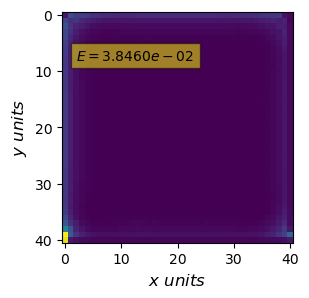

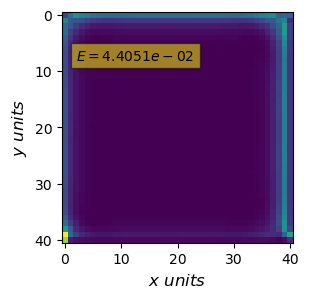

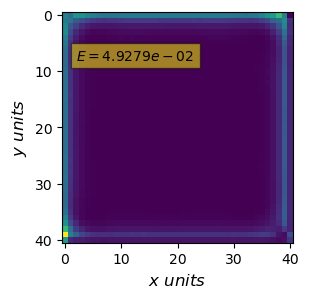

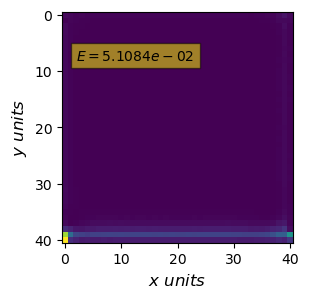

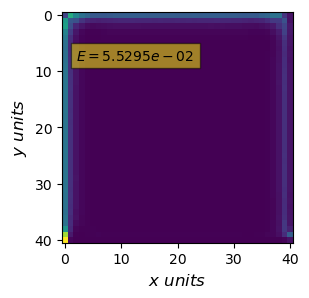

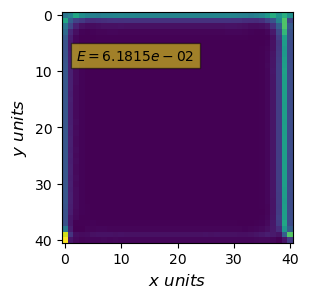

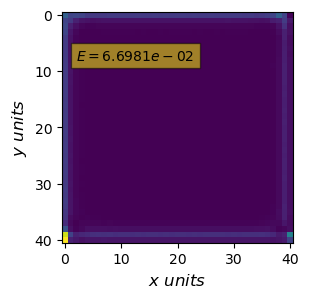

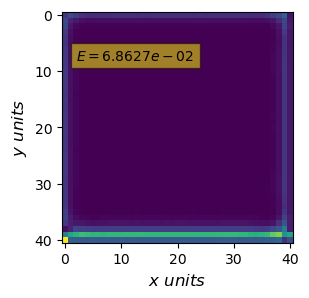

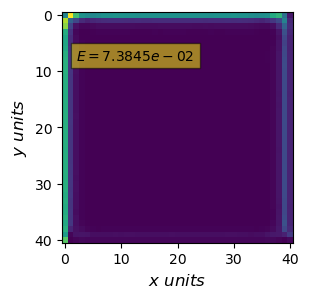

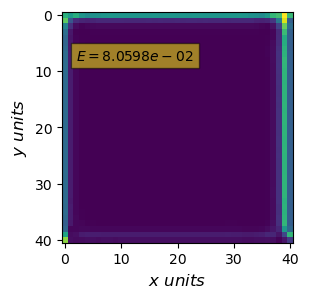

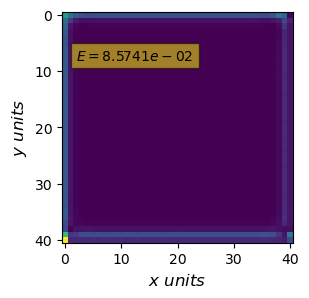

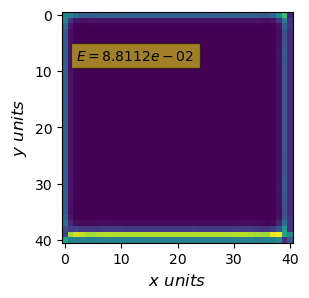

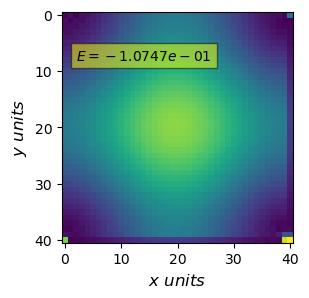

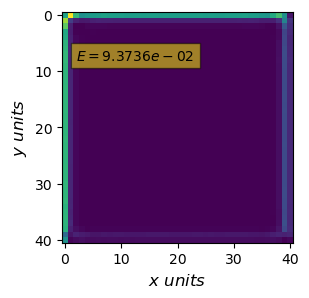

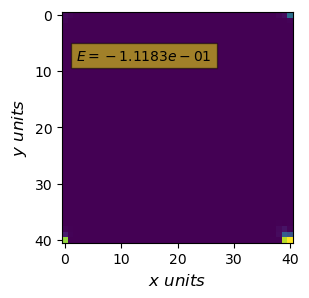

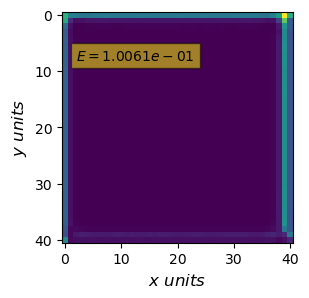

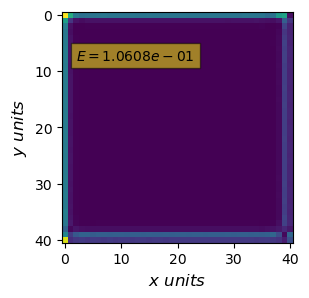

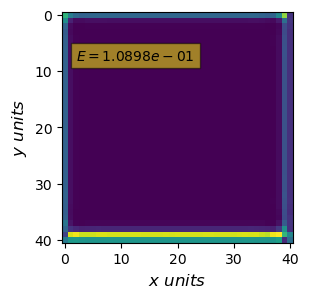

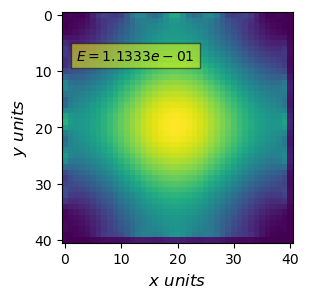

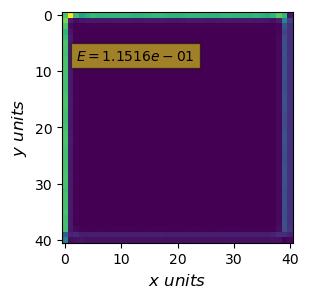

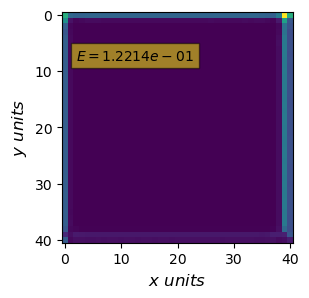

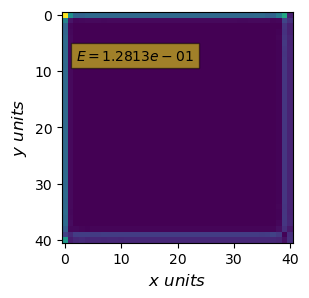

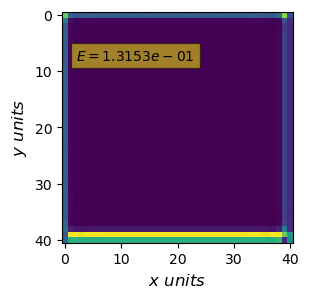

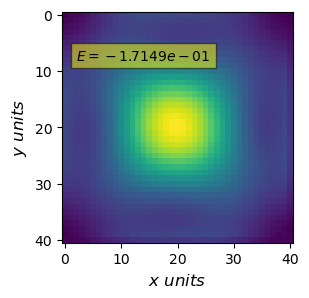

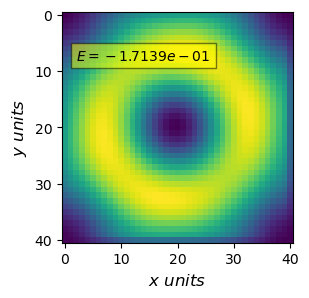

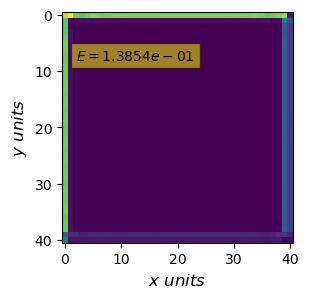

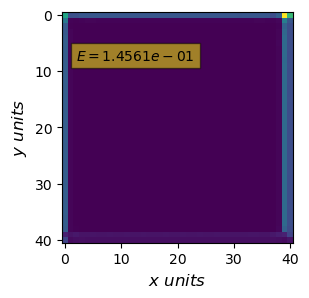

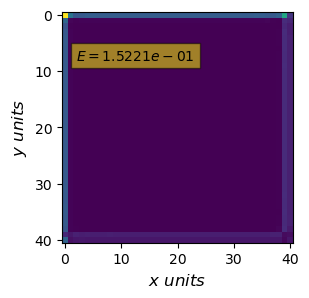

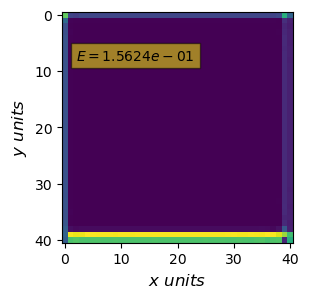

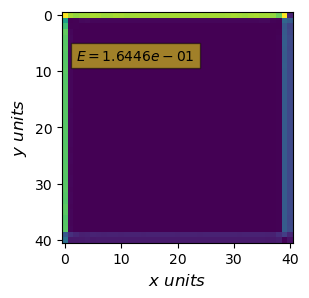

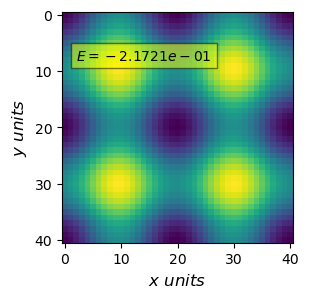

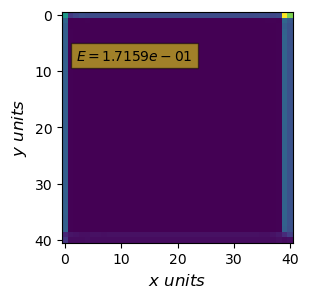

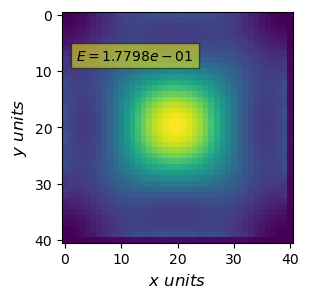

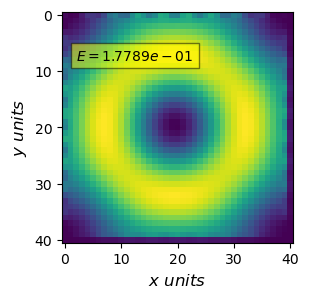

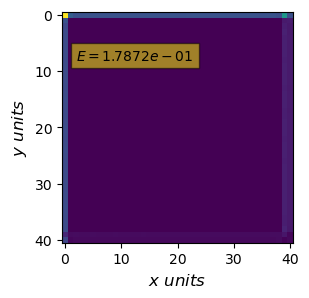

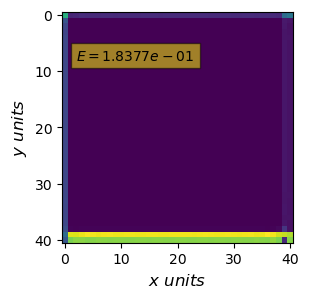

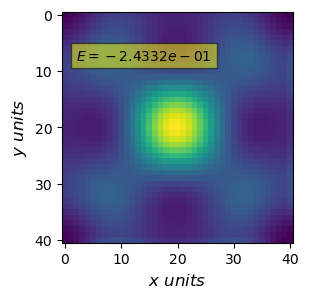

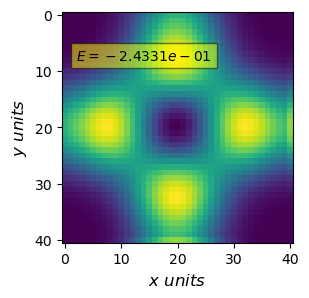

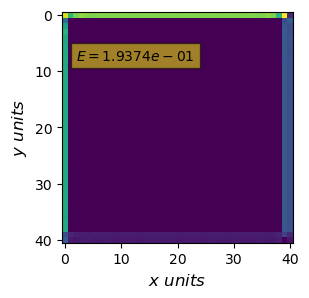

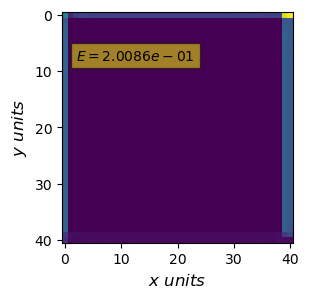

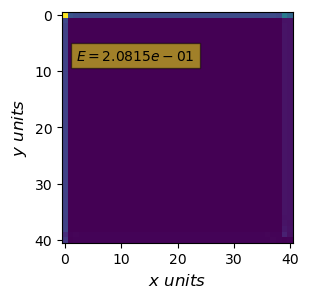

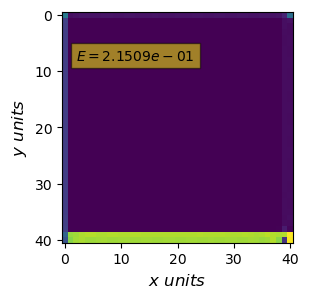

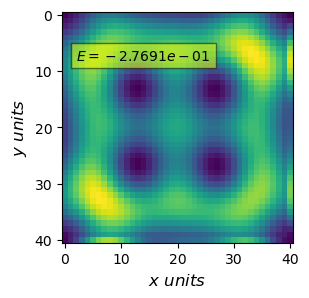

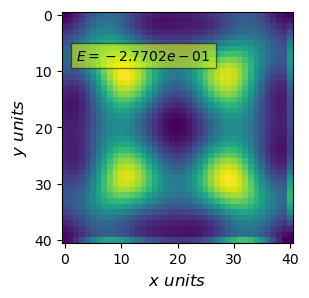

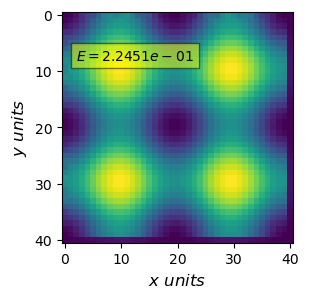

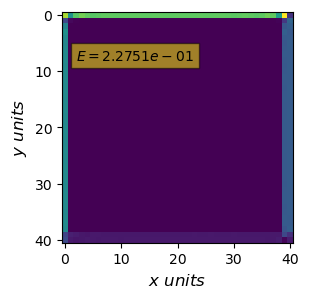

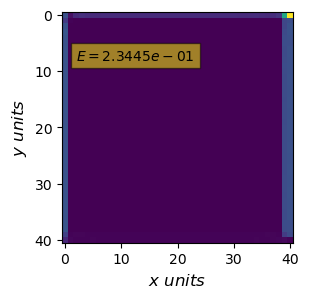

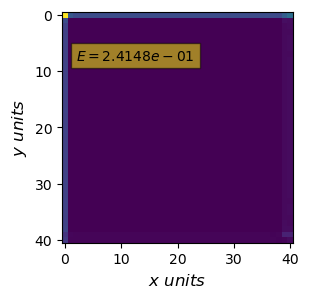

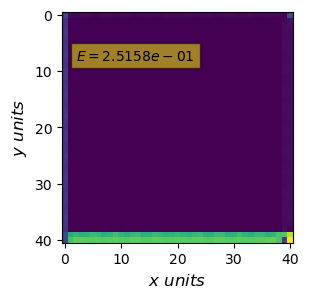

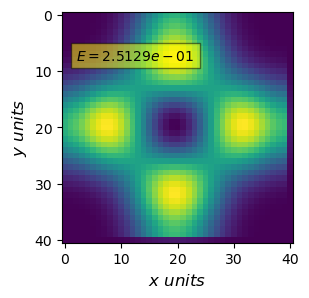

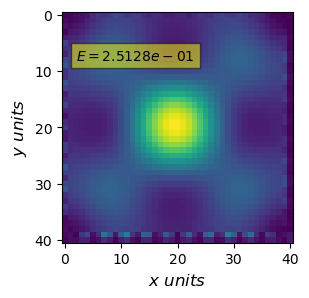

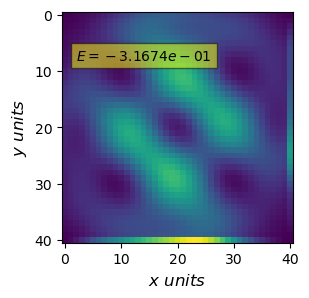

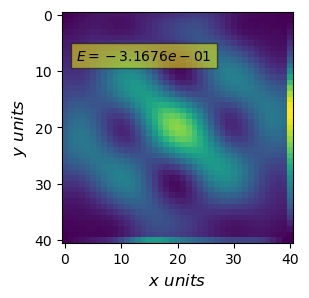

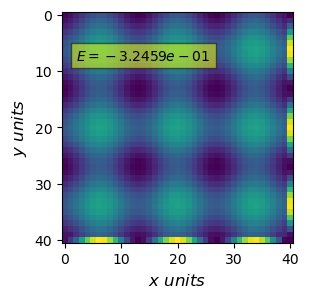

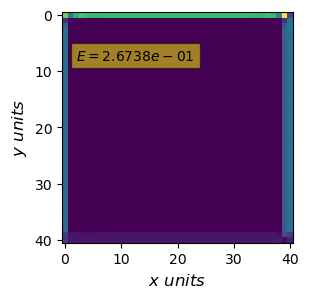

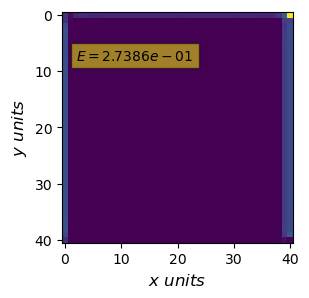

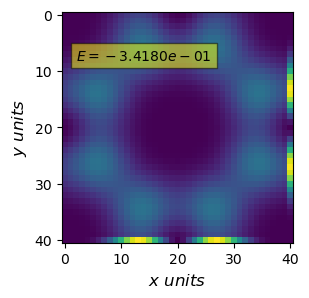

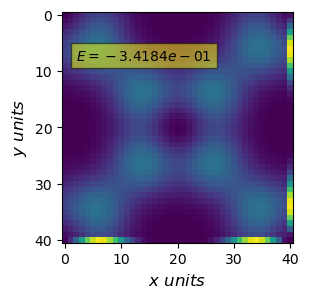

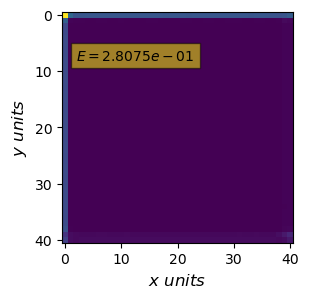

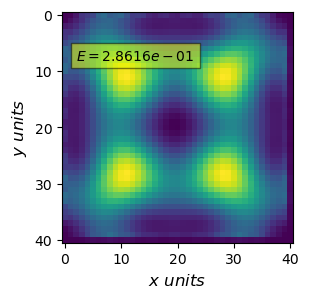

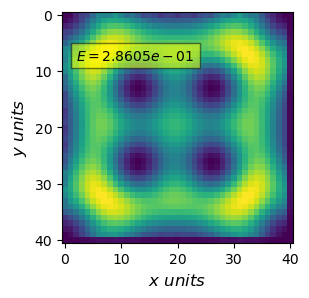

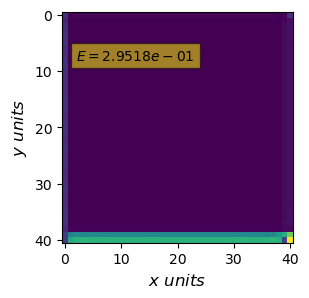

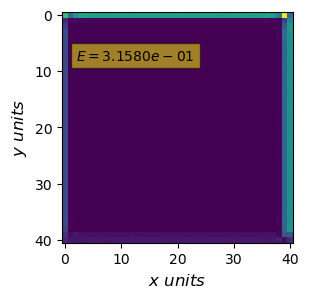

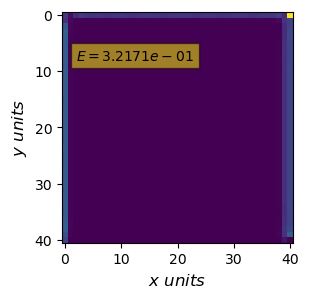

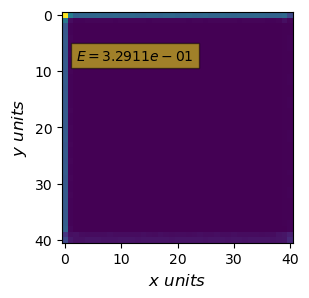

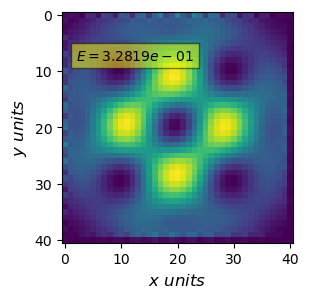

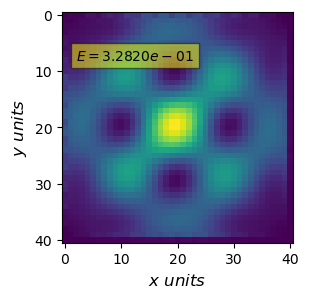

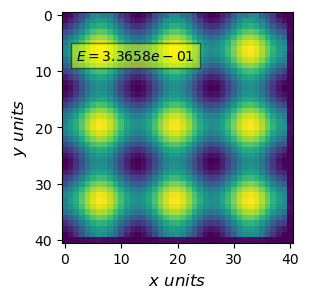

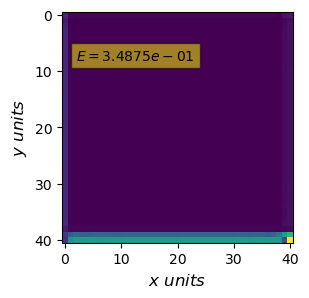

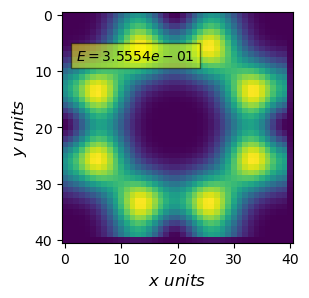

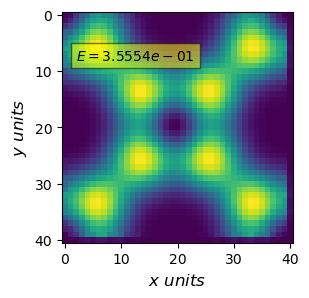

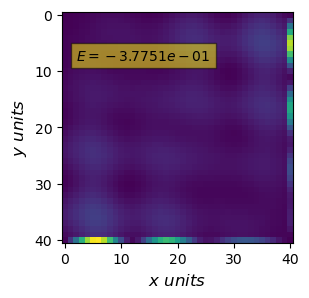

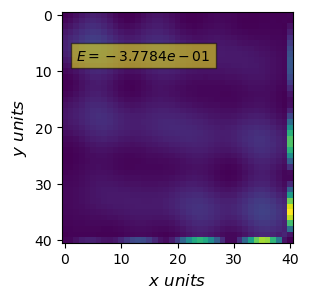

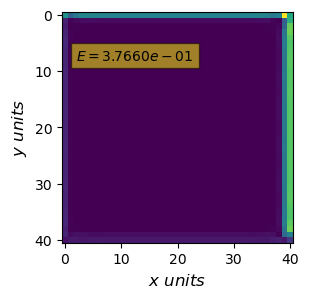

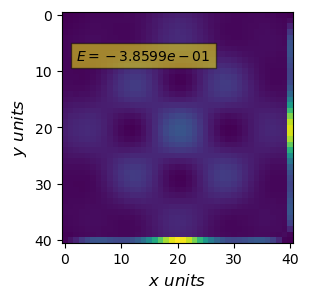

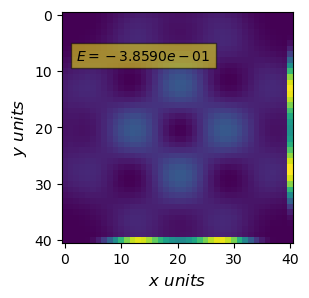

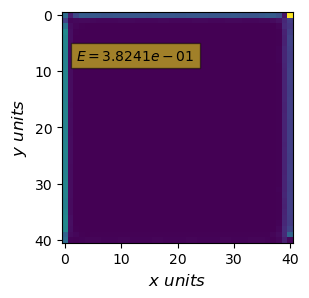

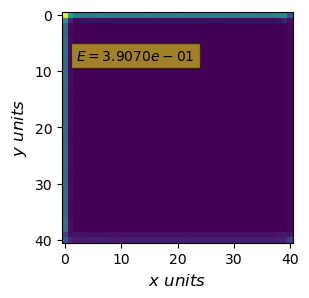

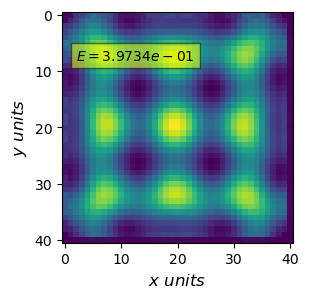

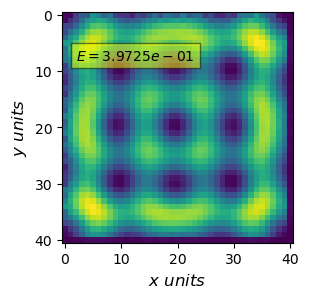

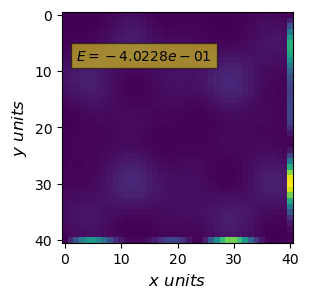

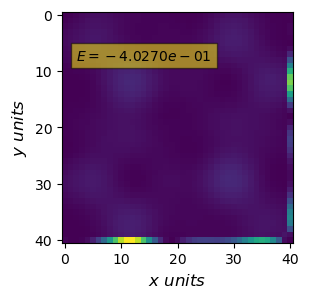

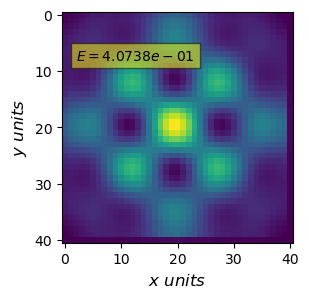

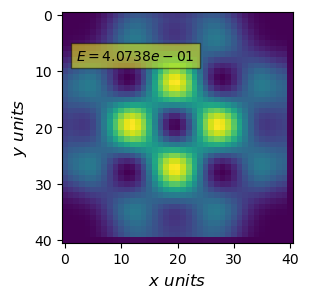

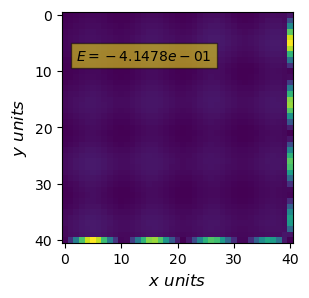

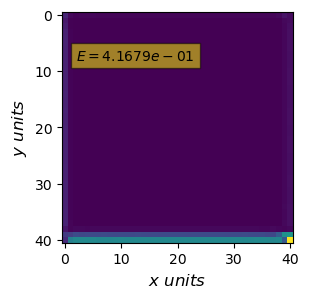

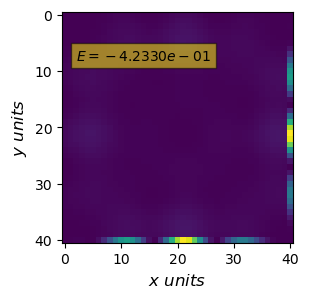

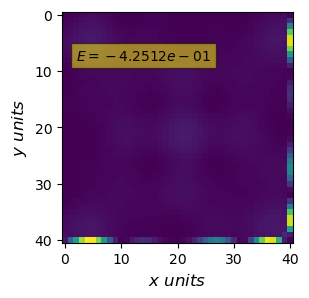

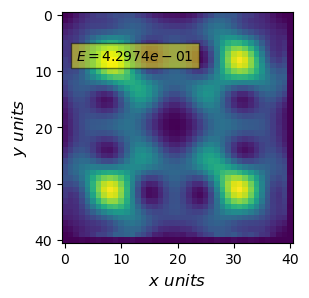

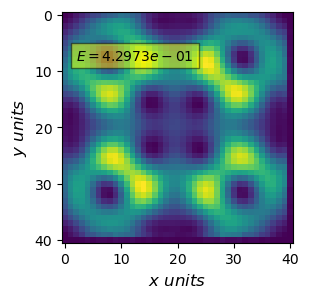

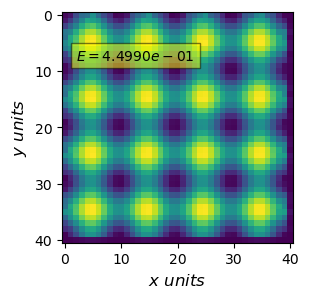

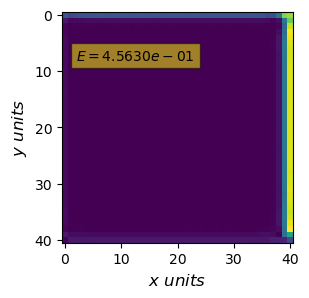

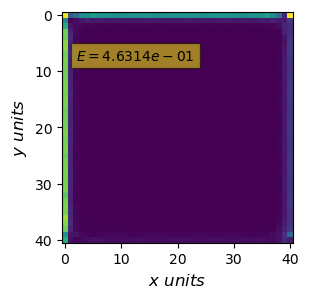

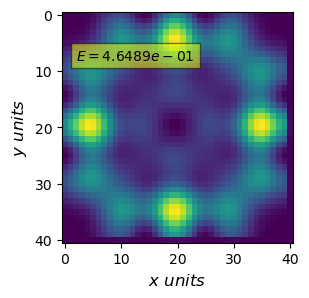

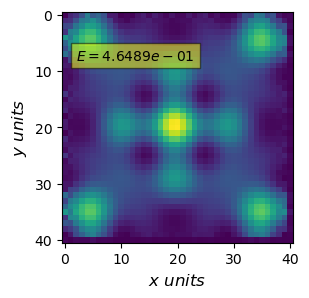

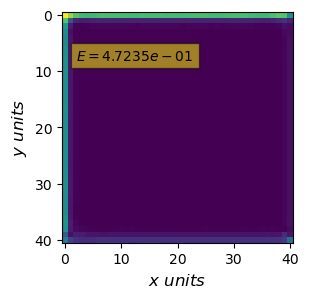

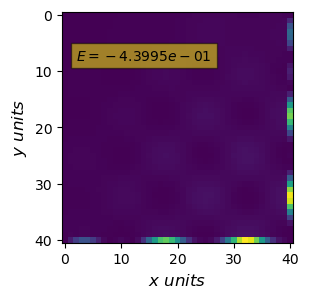

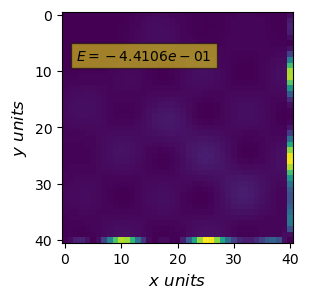

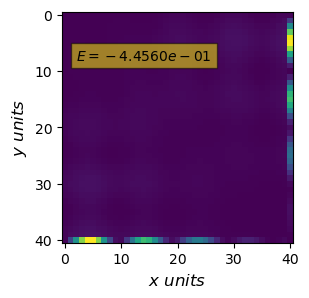

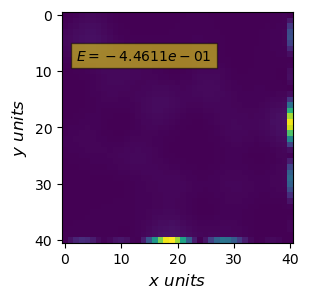

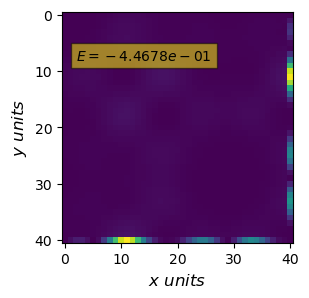

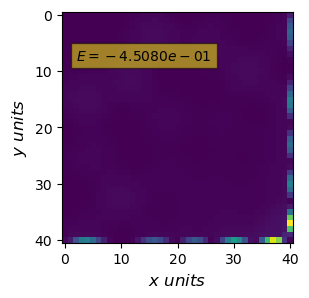

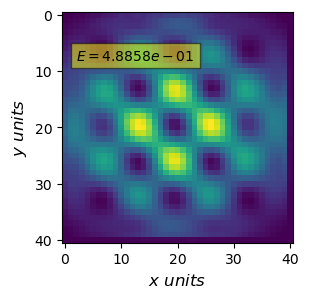

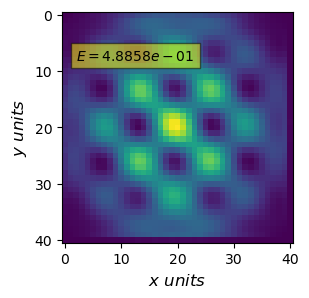

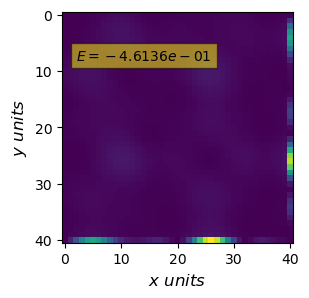

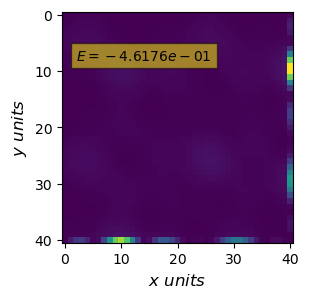

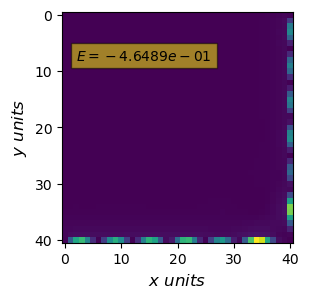

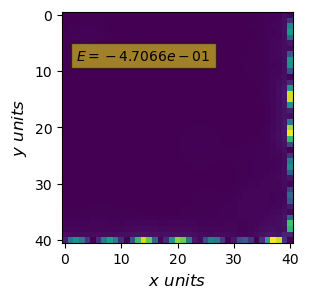

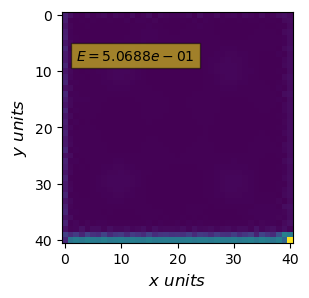

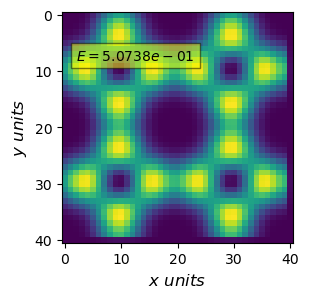

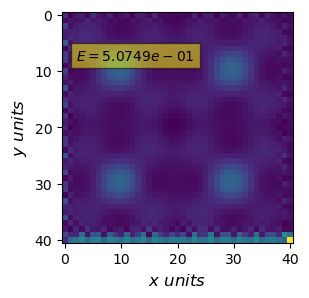

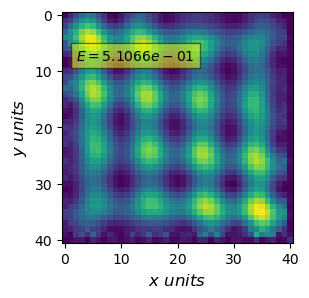

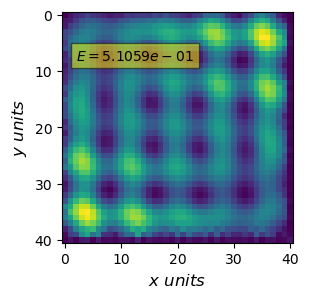

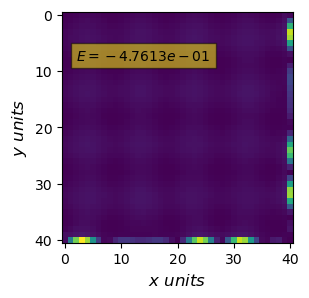

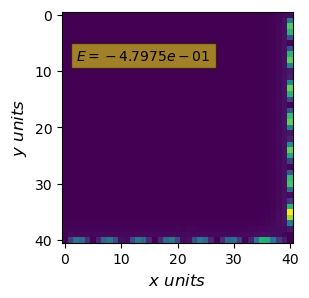

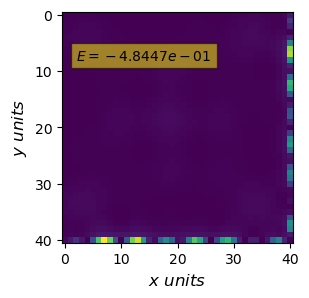

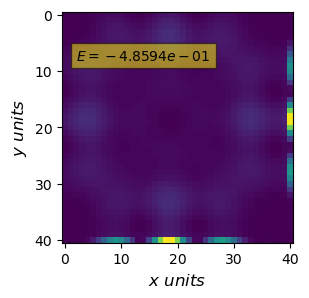

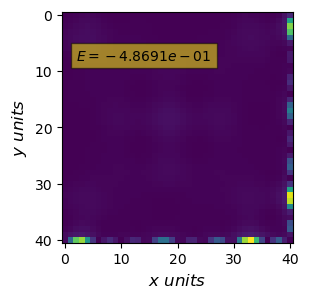

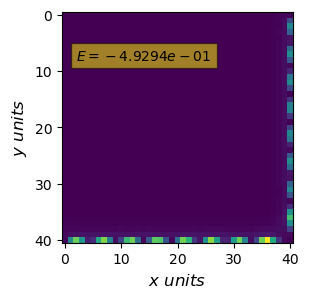

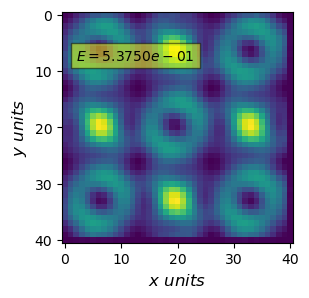

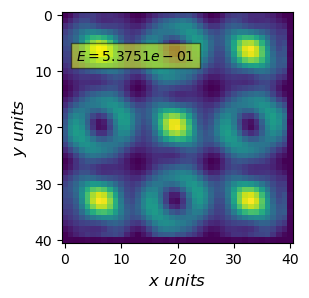

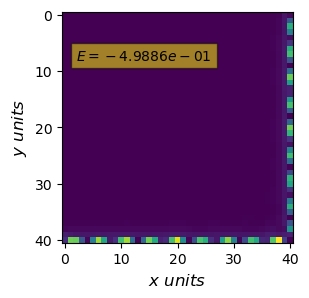

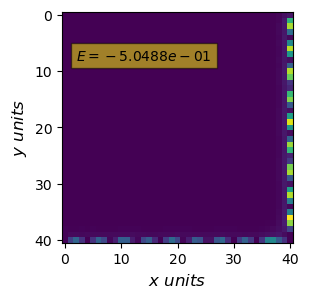

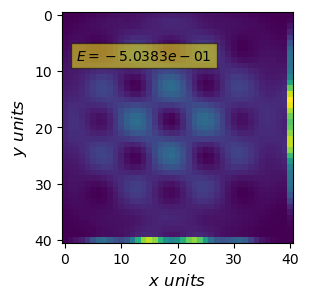

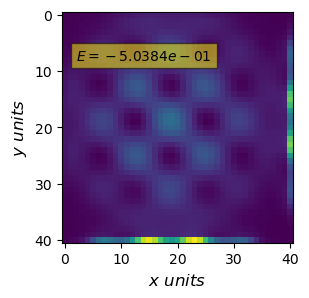

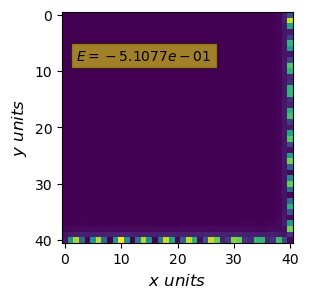

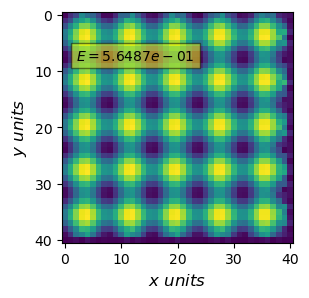

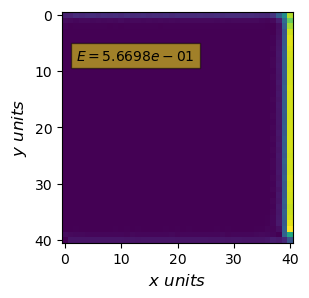

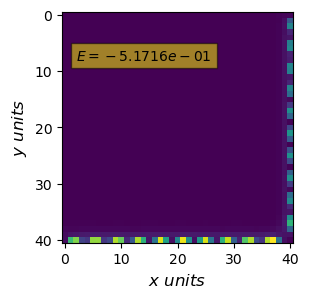

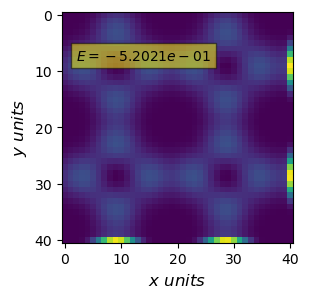

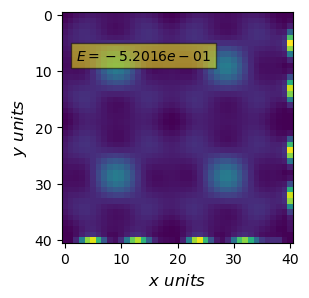

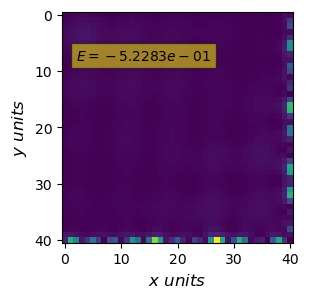

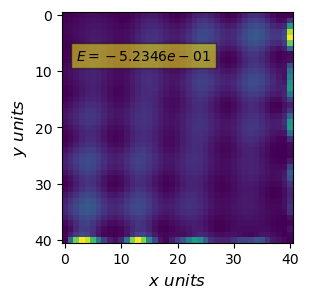

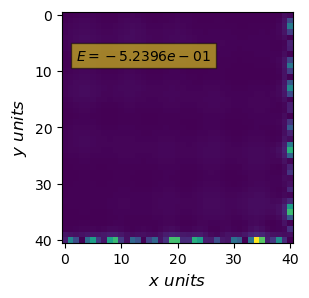

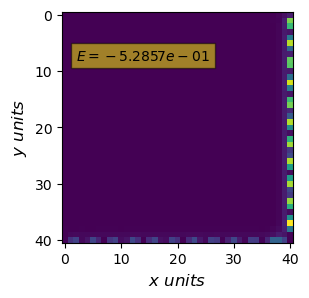

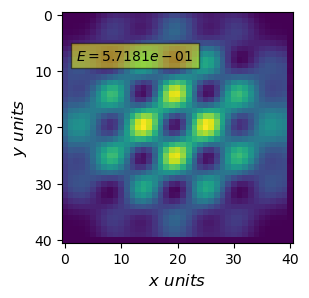

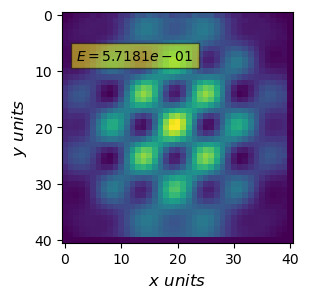

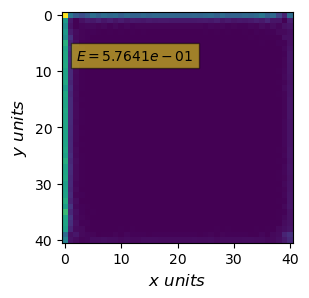

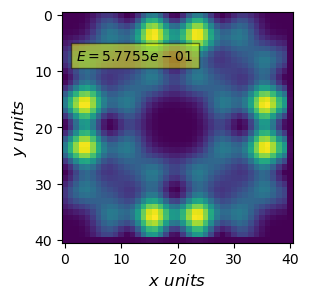

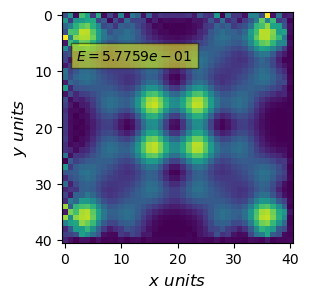

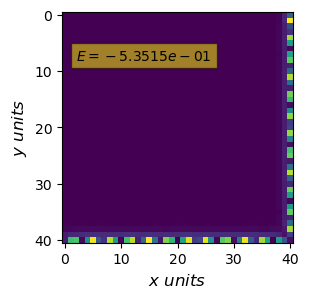

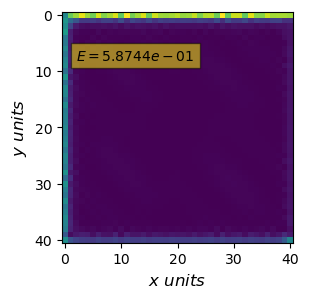

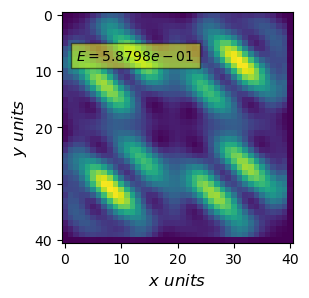

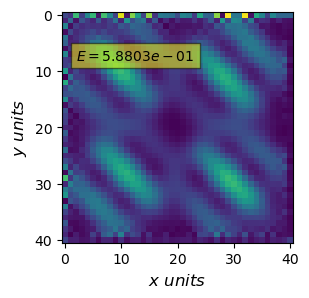

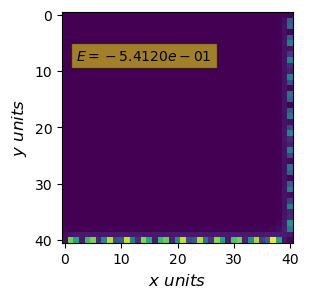

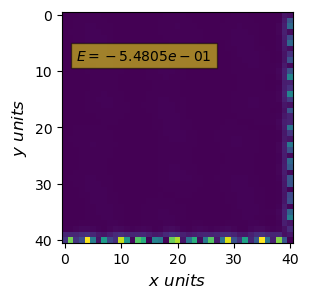

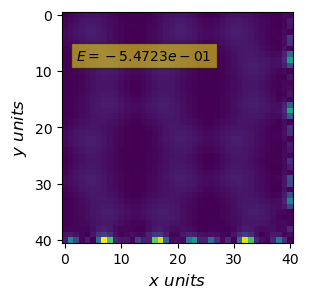

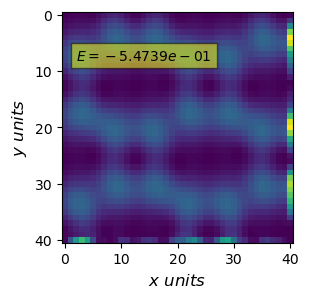

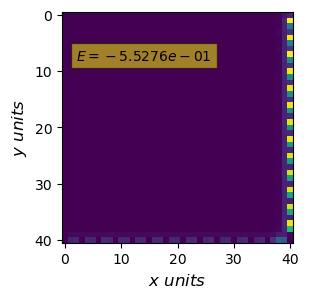

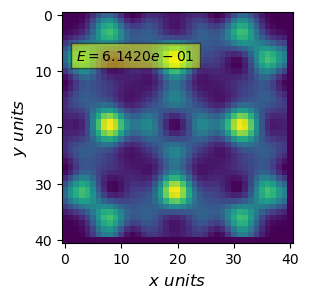

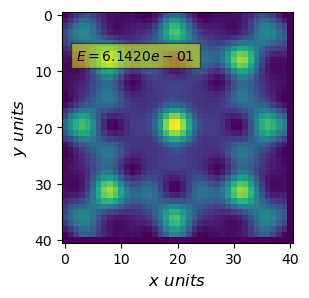

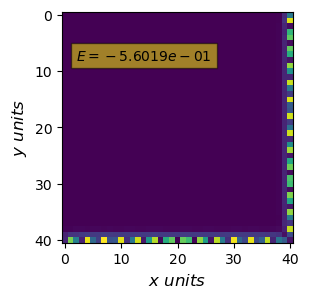

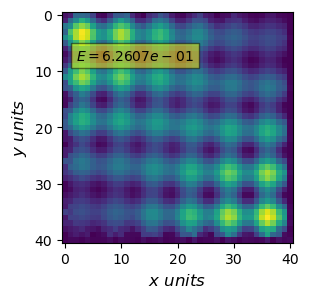

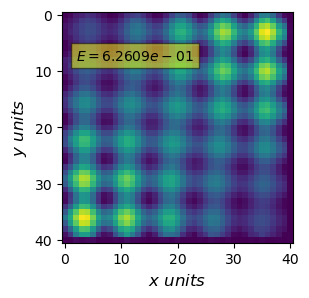

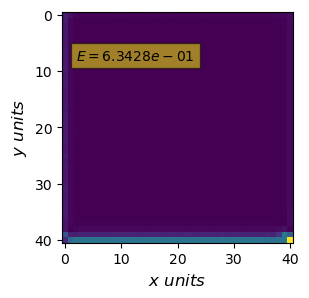

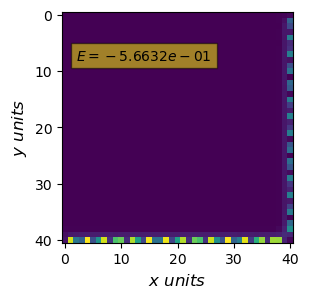

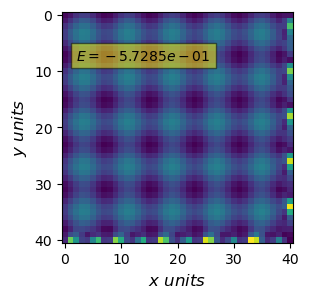

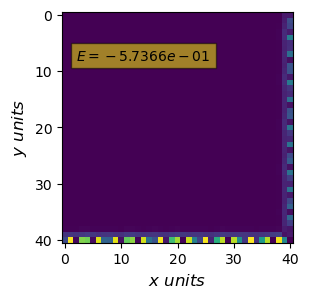

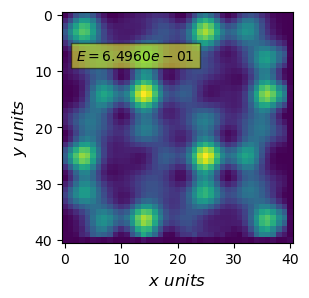

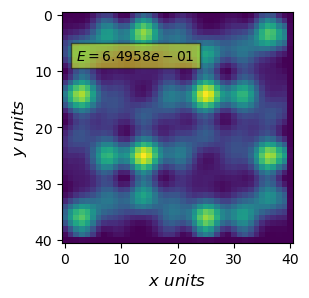

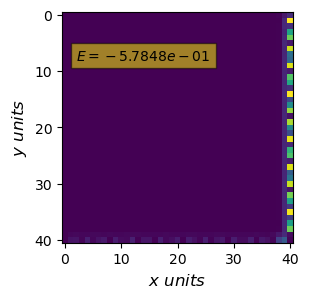

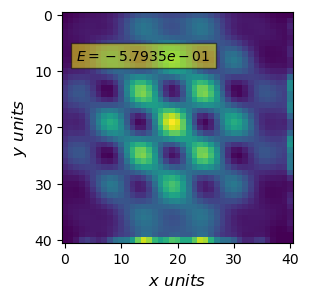

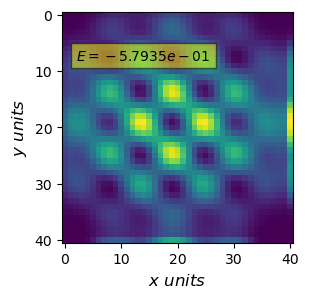

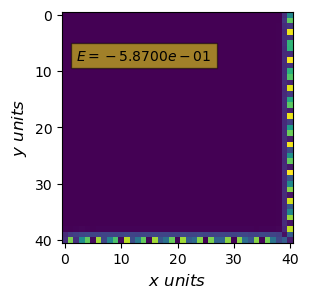

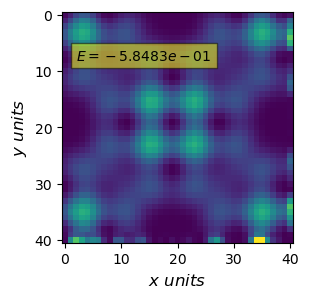

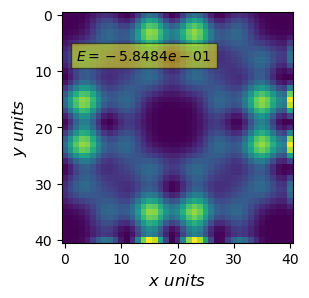

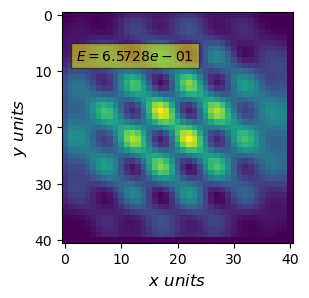

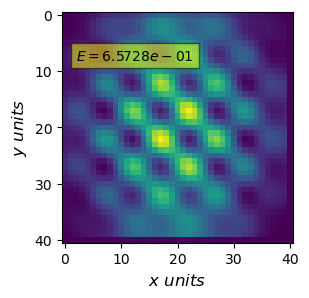

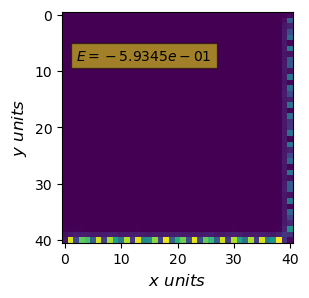

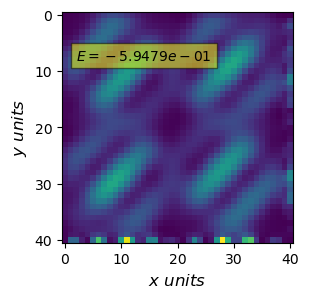

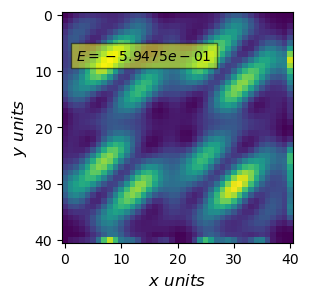

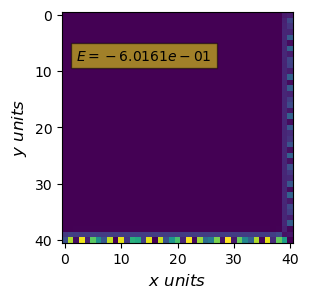

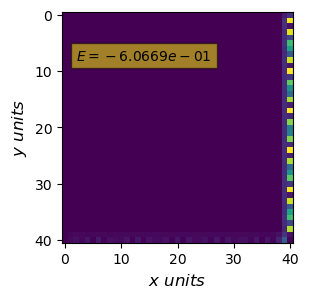

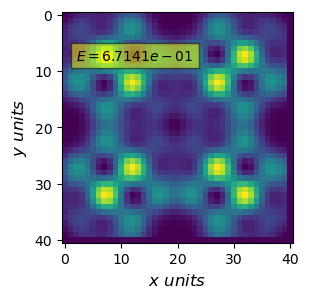

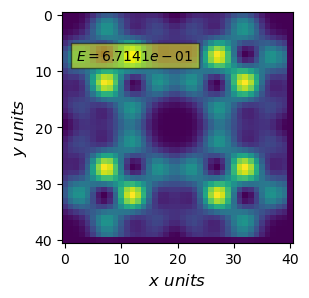

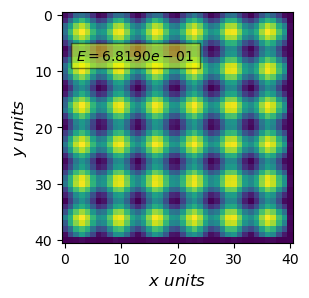

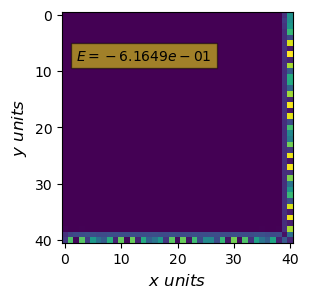

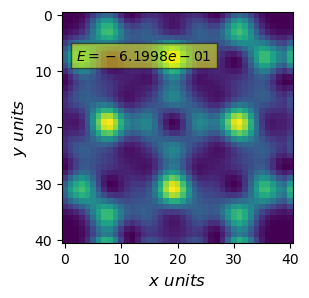

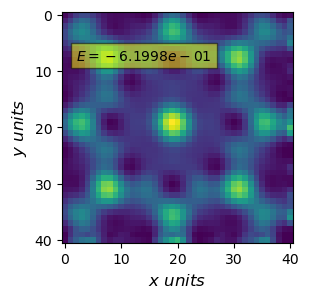

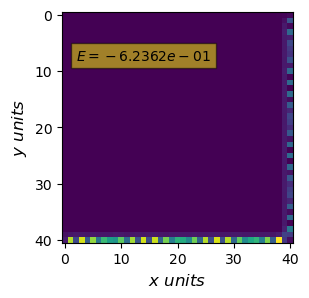

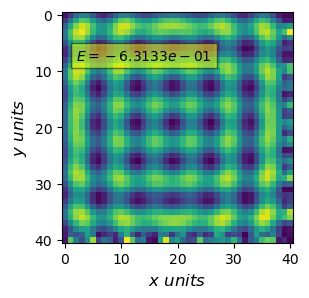

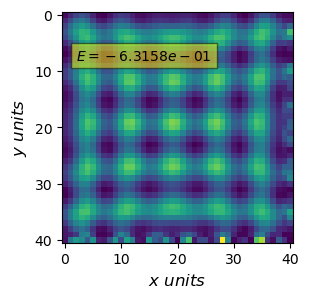

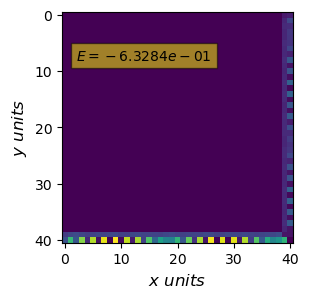

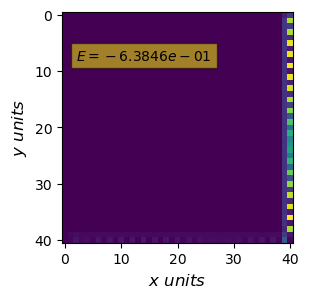

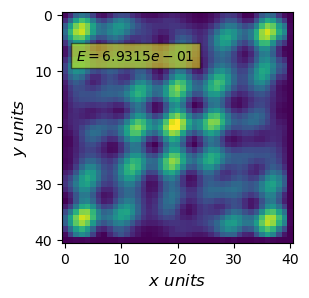

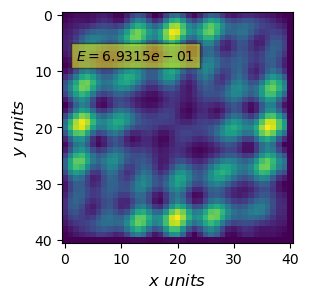

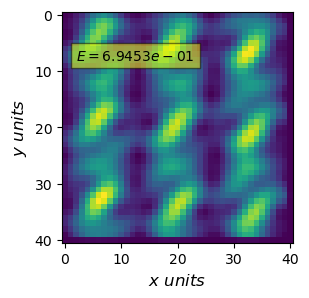

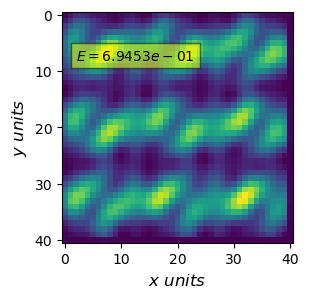

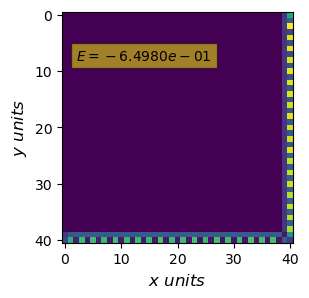

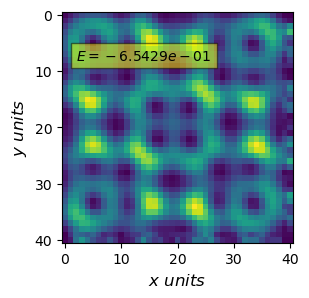

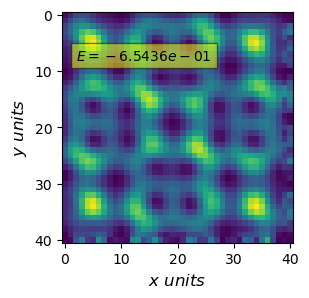

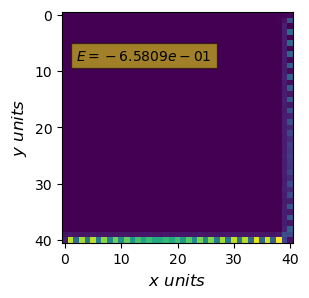

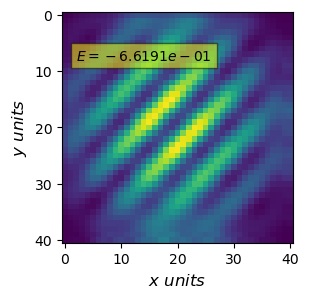

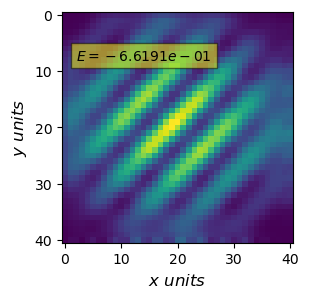

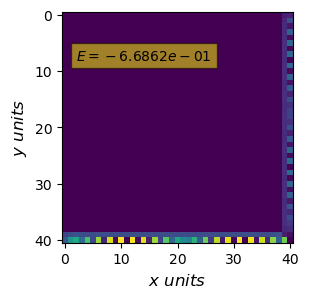

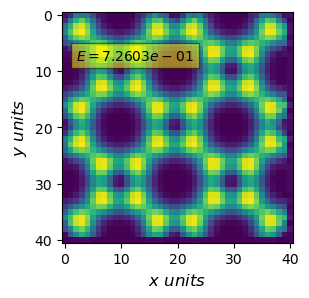

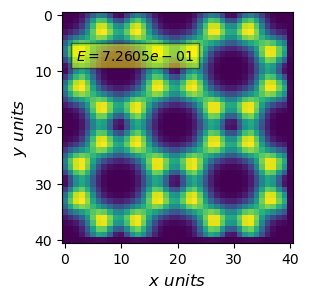

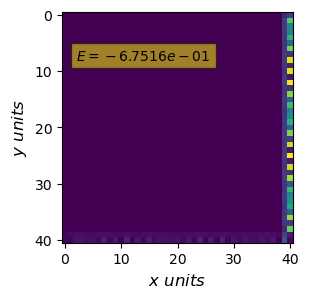

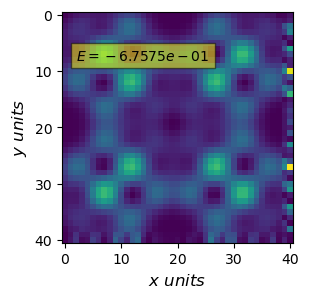

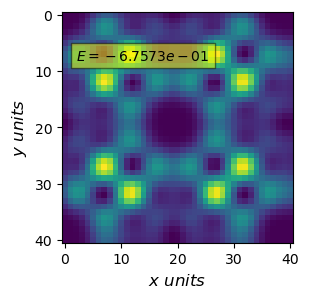

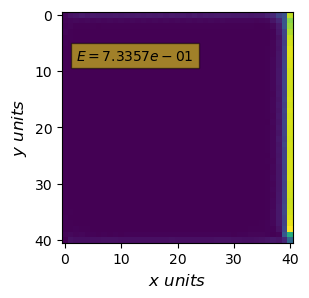

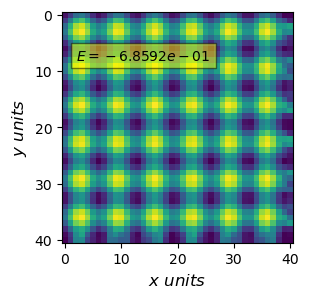

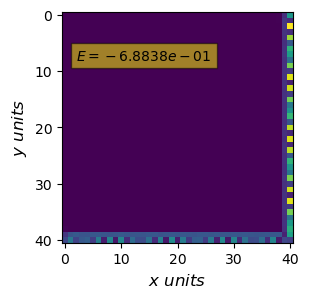

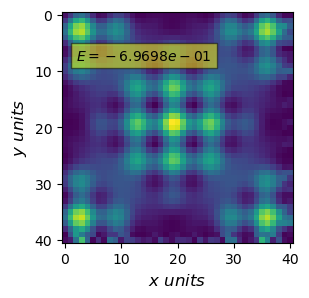

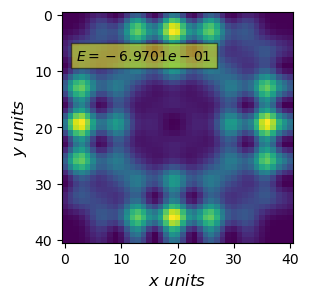

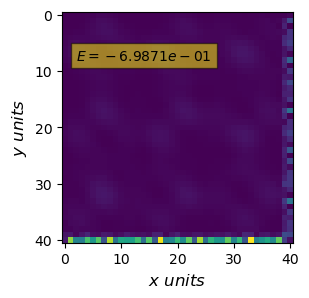

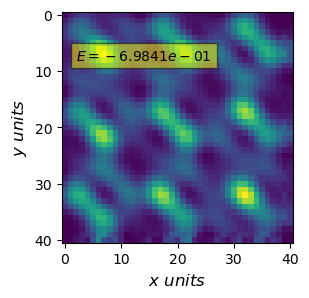

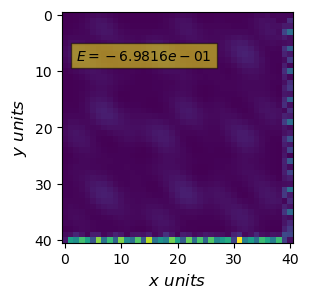

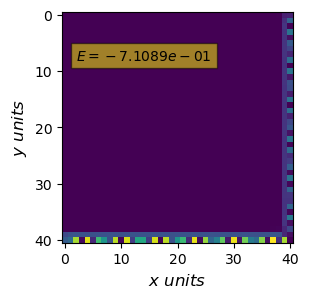

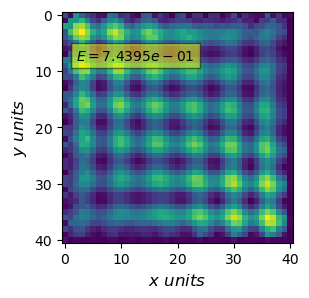

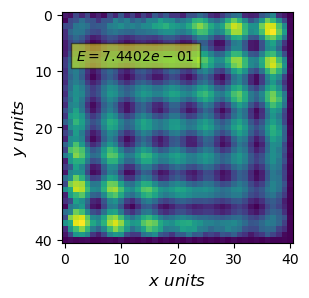

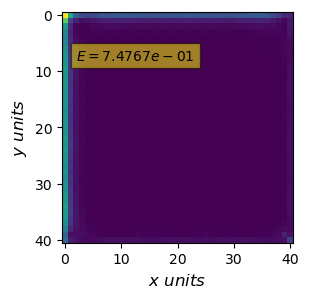

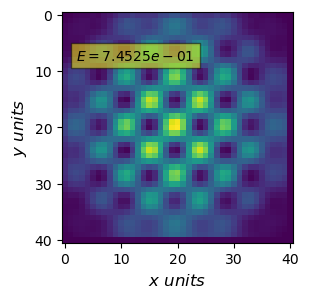

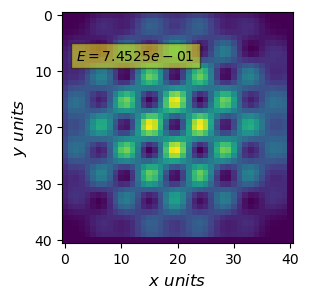

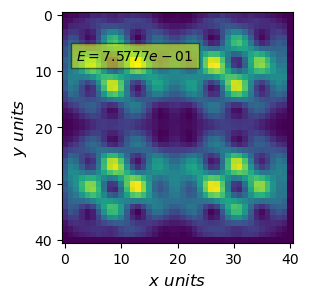

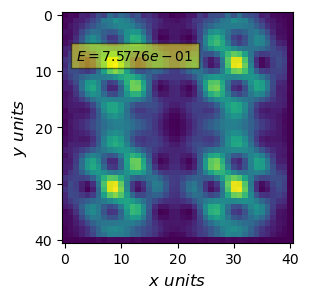

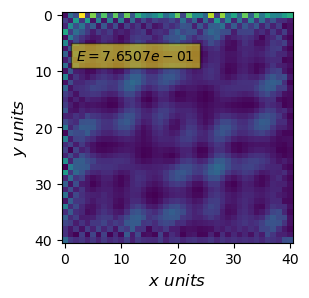

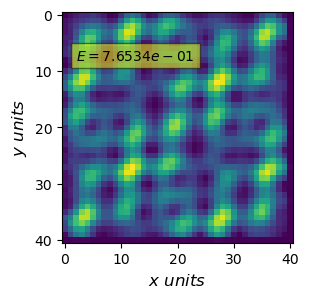

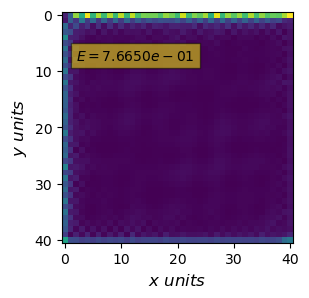

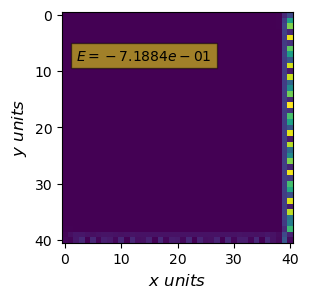

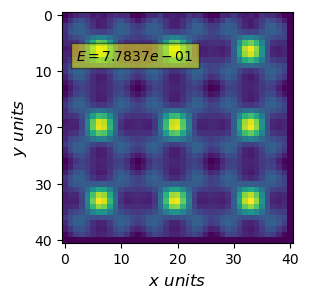

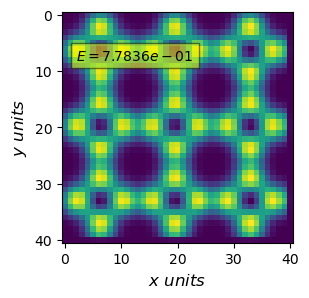

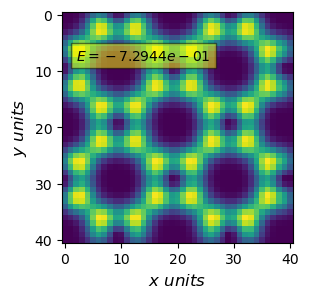

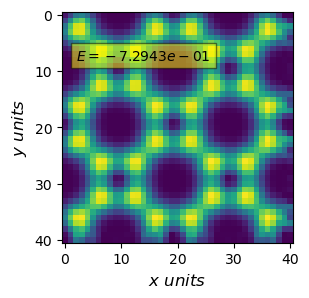

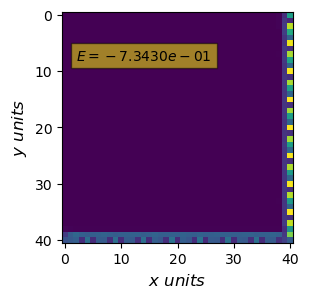

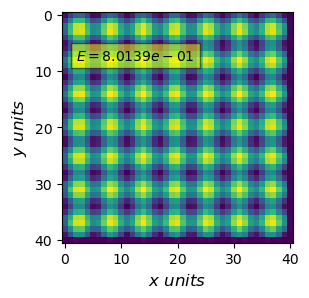

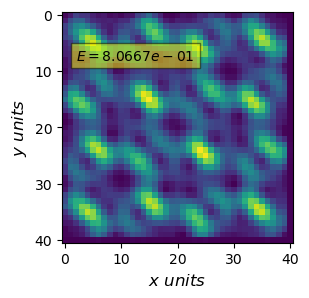

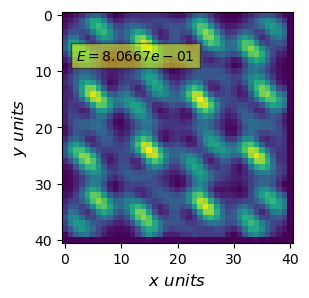

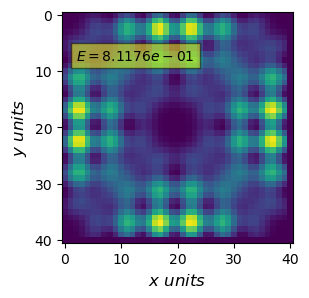

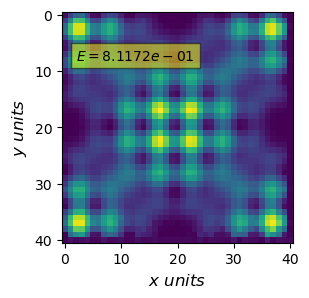

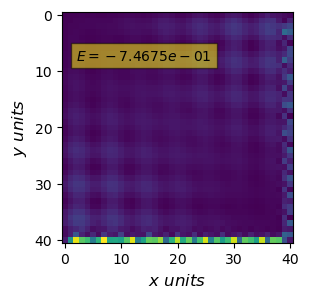

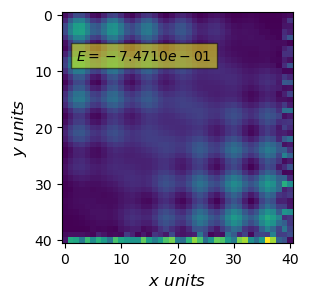

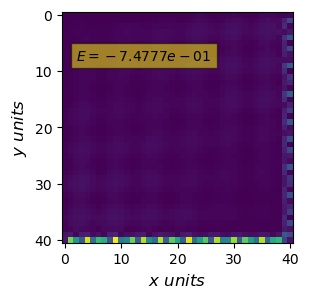

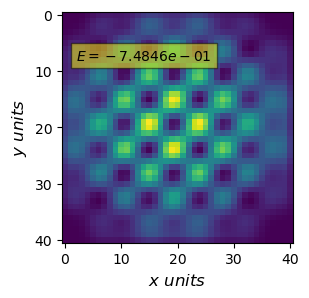

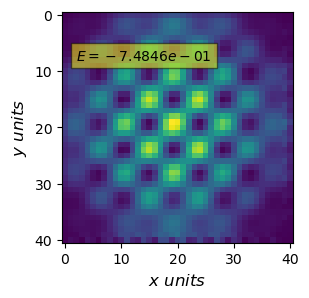

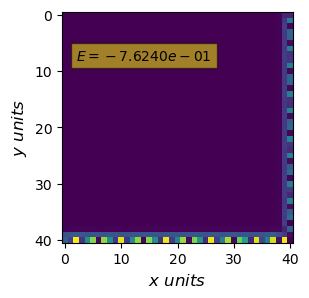

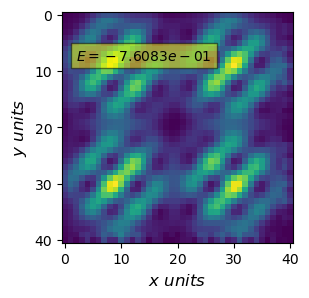

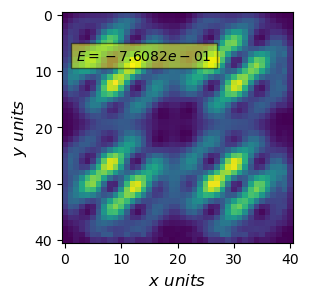

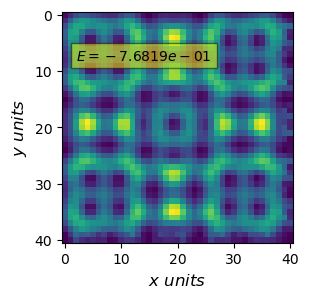

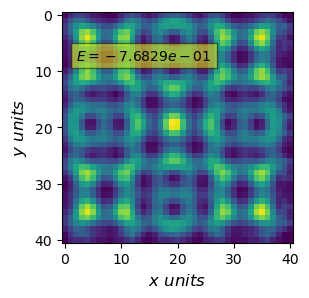

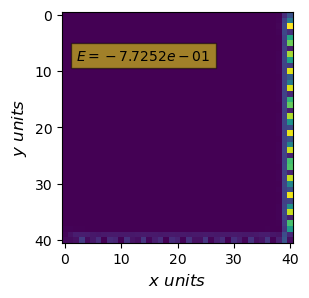

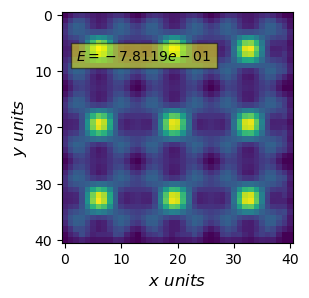

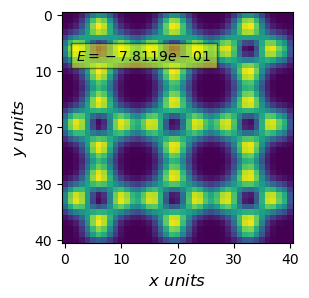

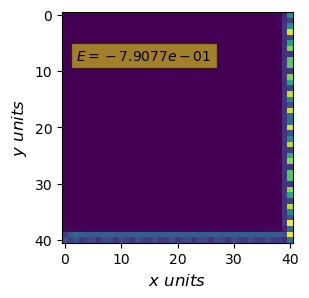

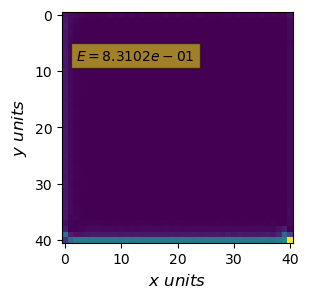

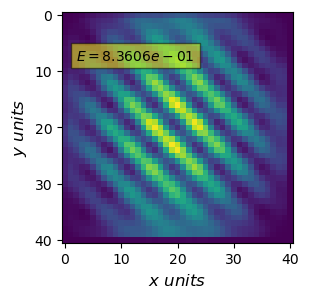

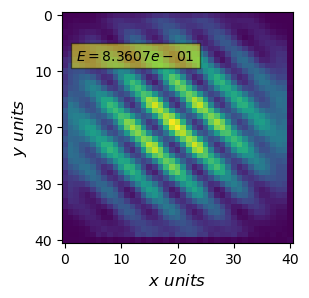

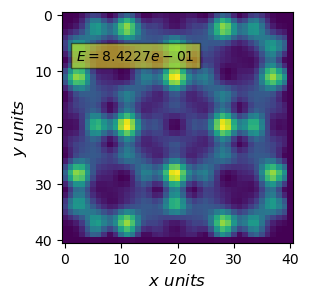

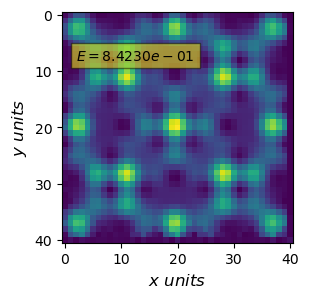

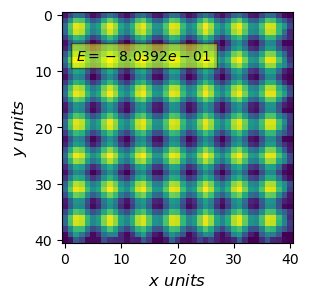

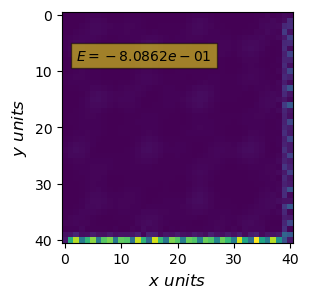

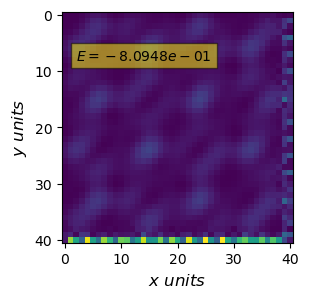

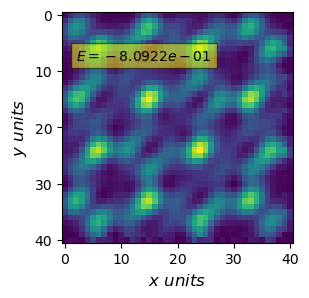

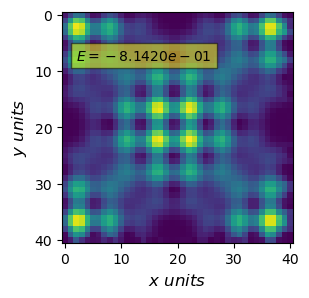

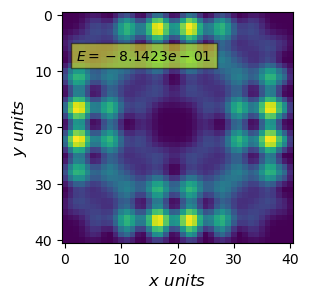

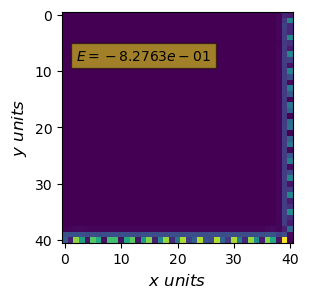

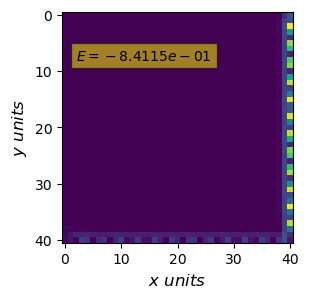

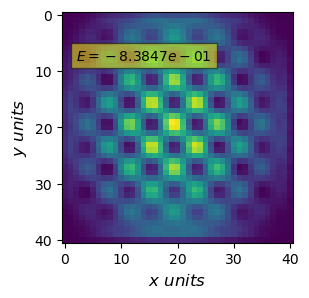

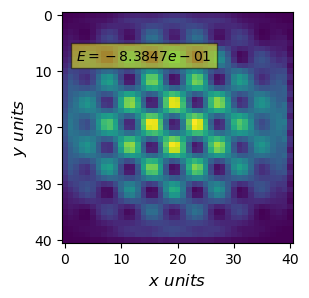

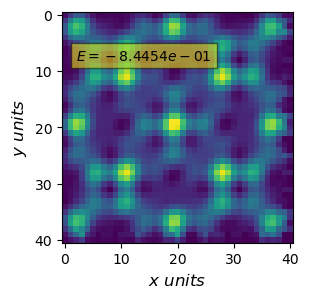

In [18]:
for i in range(nbands):
    to_plot = states[i,:,:,:]

    fig = plt.figure(figsize = (3,3))
    ax = fig.add_subplot(111)
    
    ax.imshow(np.sum(np.abs(to_plot)**2,axis = 0),vmin = 0)
    #ax.imshow(np.abs(to_plot[1])**2,vmin = 0,cmap = 'cividis') This would plot only spin down probability density
    formatted_number = f"{ener[i]:.4e}"
    plt.text(2, 8,rf'$E ={formatted_number}$' , fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))
    
    ax.set_ylabel(r"$y$ $units$",fontsize = 12)
    ax.set_xlabel(r"$x$ $units$",fontsize = 12)
    
    
    fig.show()

## Let us calculate the bands for a ribon of the same width as the square and compare them with our spectrum

In [10]:
parameters['Nx'] = 1 #Assume translational invariance in x direction
nbands = int(Ny)
npoints = 101
kmin = -pi
kmax = pi
parameters['ky'] = 0

momenta,bands = tb.make_bands_x(parameters, number_of_bands = nbands,number_of_points = npoints, kmin = -3, kmax = 3)

/tmp/ipykernel_42368/560679792.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


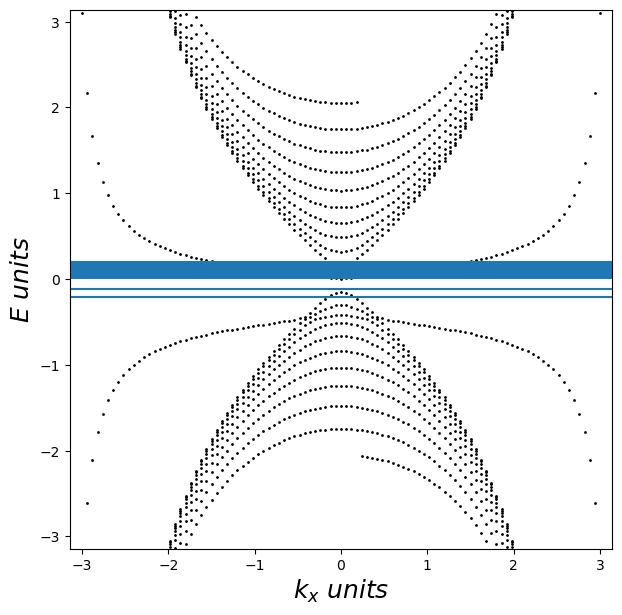

In [15]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)

for b in range(nbands):
    ax.scatter(momenta,bands[:,b], s = 1, c = 'k')
    ax.axhline(ener[b])
ax.set_xlabel(r"$k_x$ $units$",fontsize = 18)
ax.set_ylabel(r"$E$ $units$",fontsize = 18)
ax.set_xlim(-pi,pi)
ax.set_ylim(-pi,pi)

fig.show()

It seems like things are working as expected. Next step steps:

-Do nearest-neighbor level statistics

-Generalise to any shape